# Tutorial 3.1: Generating Receptive Fields with Spike-Triggered Averages

## Neuroscience goal:
- analyze receptive fields using the spike-triggered average

## Computational goals: 
- use functoins
- collapose or expand data into sets with different widths for time bins

### Tutorial overview
- simulate AELIF neuron, following dynamics described in tutorial 2.3 Q2, using parameters:
    - e_leak = -60mV
    - v_threshold = -50mV
    - v_reset = -80mV
    - delta_th = 2mV
    - g_leak = 8nS
    - c_membrane = 100pF
    - a = 10nS
    - b = 0.5nA
    - tau_sra = 50ms

- in both parts of the tutorial, goal is to use STA to assess what stimulus is best at producing spikes in the model neuron

In [3]:
# Imports
import numpy as np
import matplotlib.pyplot as plt

In [46]:
def set_params():
    """
    Reset global parameters and initialize variables for simulation
    """
    global e_leak, v_threshold, v_reset, delta_th, g_leak, c_membrane, a, b, tau_sra, v_peak, r_membrane

    e_leak = -60           # Leak potential, mV
    v_threshold = -50      # Spike threshold, mV
    v_reset = -80          # Reset potential, mV
    delta_th = 2           # Threshold decay, mV
    g_leak = 8e-9          # Leak conductance, S
    c_membrane = 1e-10     # Membrane capacitance, F
    r_membrane = 100e6     # Membrane resistance, Ohm
    a = 10e-9              # I_SRA control term, S
    b = 5e-10              # I_SRA current step, A
    tau_sra = 50e-3        # SRA time-constant
    v_peak = 40            # Spike uptick, mV

## Part A: Time-Varying Stimulus
- will treat stimulus as a single input current that varies over time and assess what temporal variation of the stimulus is most likely to lead to a spike in the model neuron
- will use a stimulus held constant for 5ms, then randomly replaced with a new stimulus

### 1.
- first goal is to simulate a neuron and record spike times 

#### a. 
- produce a vector of 40,000 values for the applied current, with each value chosen randomly from a uniform distribution between -0.5 and +0.5 nA
- values will be used to produce successive 5ms blocks with the current fixed in each 5ms block


In [32]:
currents = np.random.uniform(-5e-7, 5e-7, 40000)

#### b. 
- create a time vector in steps of 0.02ms up to a total time of 40,000x5ms and an applied current vector of the same size as time vector
- current vector should contain 40,000 randomly generated values from 1a), with each value repeated for 250 timesteps, so applied current is constant for 5ms before changing to new value


In [188]:
tmax = 40000*5e-3
dt = 0.02e-3
t = np.arange(0, tmax, dt)
i_app = np.repeat(currents, 250)

#### c. 
- simulate AELIF neuron with applied current vector from 1b) using preceding parameters and equations for tutorial 2.3 Q2
- use simulation timestep dt = 0.02ms
- ensure all spikes are recorded in a vector of the size of the time vector with a 1 in each time bin that a spike occurs and 0s otherwise

In [215]:
# AELIF NEURON
def run_aelif(i_app=i_app, sigma=0):
    
    v_sim = np.zeros_like(t)
    v_sim[0] = e_leak
    i_sra = np.zeros_like(t)
    i_sra[0] = 0
    spike_times = np.zeros_like(t)
    
    for i in range(1, t.shape[0]):
        # New noise term each simulation
        noise = np.random.rand() * sigma * np.sqrt(dt)
        
        # Membrane potential ODE
        dvdt = (g_leak*((e_leak - v_sim[i - 1]) + delta_th * np.exp((v_sim[i - 1] - v_threshold)/delta_th)) - i_sra[i - 1] + i_app[i]) / c_membrane
        # Forward Euler update
        v_sim[i] = v_sim[i - 1] + (dt * dvdt) + noise
        
        # SRA current ODE
        didt = ((a * (v_sim[i - 1] - e_leak)) - i_sra[i - 1]) / tau_sra
        # Forward Euler update
        i_sra[i] = i_sra[i - 1] + (dt * didt) + noise
        
        if v_sim[i] >= v_threshold:
            v_sim[i] = v_reset
            i_sra[i] = i_sra[i] + b
            v_sim[i - 1] = v_peak
            spike_times[i] = 1
        
    return v_sim, spike_times

In [208]:
set_params()
v_sim, spike_times = run_aelif(i_app, 0)

### 2.
- to improve efficiency of analysis, we will *downsample* the simulus and spike ectors
- best achieved by writing a function _expandbin(initial_vector, initial_width, final_width)_
    - returns output vector of smaller size than initial vector, with size reduced by factor equal to ratio of bin widths
    - in this case, are simulating a neuron with time bin of 0.02ms, but only interested in changes on a timescale of 1ms(+)

#### a. 
- to downsample:
    - create function _expandbin()_
    - find length of old vector and divide by scaling ratio of new/old bin size
    - populate the new vector with the mean of successive blocks of entries of old vector

In [209]:
def expandbin(initial_vector, initial_width, final_width):
    """
    Downsamples input vector by averaging values within specific widths
    Args:
        initial_vector (ndarray): input vector to be downsampled
        initial_width (float): width between data points in old vector
        final_width (float): width between data points in new vector
    Returns:
        result (ndarray): downsampled vector
    """
    ratio = int(round(final_width / initial_width))
    new_length = int(np.ceil(len(initial_vector) / ratio))
    
    reshaped_vector = initial_vector[:new_length * ratio].reshape(new_length, ratio)
    result = np.mean(reshaped_vector, axis=1)
    
    return result


#### b. 
- send to the function the applied current vector with dt = 0.02ms and new_dt = 1ms
- send to the function the simulated vector of spike times
    - since the spikes are defined as binary, change the reduced spike values in the return vector back to 1

In [210]:
new_dt = 1e-3
# Downsample applied current vector
ds_i_app = expandbin(i_app, dt, new_dt)
# Downsample spike time vector
ds_spike_times = expandbin(spike_times, dt, new_dt)
# Set reduced spike values back to 1
ds_spike_times = np.where(ds_spike_times > 0, 1, ds_spike_times)


### 3.
- produce and plot STA derived from the two downsample stimulus and spike time vectors
- create and use another function, _sta()_, to achieve this

#### a. 
- create the function:

In [212]:
def get_sta(i_app, spikes, dt, t_minus=75e-3, t_plus=25e-3):
    """
    Computes spike-triggered average
    Args:
        i_app (ndarray): vector of applied currents
        spikes (ndarray): vector of binary values indicating spike times
        dt (float): time step
        t_minus (float, optional): time before spike
        t_plus (float, optional): time after sike
    Returns:
        sta (ndarray): spike-triggered average at each timestep
        tcorr (ndarray): time window vector
    """
    # Number of time steps before and after spike
    n_minus = int(np.ceil(t_minus/dt))
    n_plus = int(np.ceil(t_plus/dt))
    
    # Initialize time window
    t_corr = np.arange(-dt*n_minus, dt * (n_plus + 1), dt)
    
    # Find spike timepoint indices
    spike_indices = np.where(spikes)[0]
    
    indices = spike_indices[:, np.newaxis] + np.arange(-n_minus, n_plus + 1)
    indices = np.clip(indices, 0, len(i_app) - 1)
    spike_values = i_app[indices]
    sta = np.mean(spike_values, axis=0)
    
    return sta, tcorr

#### *Note*:
- it is easiest to ignore the spikes too near the beginning or end of the stimulus
- if the time window for the STA is not much smaller than the stimulus duration, it is better if they are not ignored
    - to avoid a loss of a large fraction of the data
    - must be careful when averaging the stimulus: values in each time bin should be divided only by the number of spikes that contribute to that time bin, rather than the total number of spikes
    - value of stimulus before/after end of trial is assumed to be zero, so a spike very early in the trial would otherwise contribute a lot of unwanted zeros to the average stimulus at earlier times


#### b. 
- send downsampled applied current and spike train to the function get_sta()

In [213]:
sta, tcorr = get_sta(ds_i_app, ds_spike_times, new_dt)
sta
print(len(sta), len(tcorr))

101 101


#### c.
- plot the STA as a function of the time window around the stimulus
- to adopt conventional coordinates, x-axis should be the negative of the time window, to represent the time lag of the spike after the stimulus that produced it
- STA at positive values of x denote a positive relationship


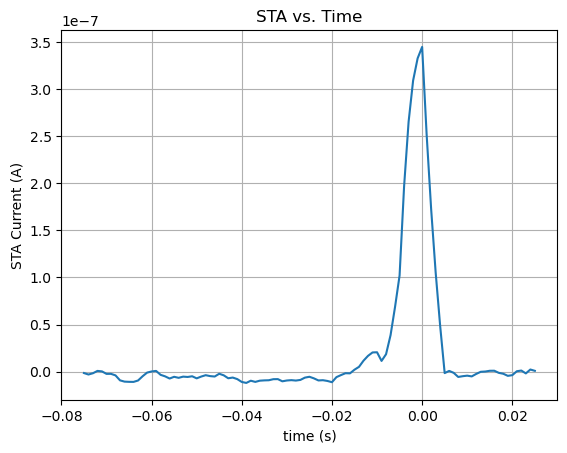

In [214]:
plt.plot(tcorr, sta)
plt.title('STA vs. Time')
plt.xlabel('time (s)')
plt.ylabel('STA Current (A)')
plt.grid()

### Part B: Spatiotemporal Stimulus
- include a stimulus that varies in both space and time
- assume neuron's input current is a linear combination of the values of the stimulus at each spatial location
    - weighted sum (where weights can be negative)
- neuron receives a time-varying input current as in part A, but at each point in time the value of the input current depends on many values of the spatially varying stimulus
- worth noting that while we discuss the additional coordinate of the stimulus as being spatial, the math aand code are identical if the stimulus coordinate is the frequency of an auditory stimulus

#### 1a. 
- generate an array of 40 rows by 40,000 columns to ocntain the stimulus, S(x,t), with each entry randomly chosen from a uniform distribution between -0.5 and 0.5 nA


#### 1b. 
- assume the row number corresponds to the spatial coordinate, x, (with x_max = 40) and the input current to the cell, i_app(t), is given by the weighted sum of the stimulus at each spatial coordinate
- according to:
$$I_{app}(t) = \Sigma^{X_{max}}_{x=1}W(x)S(x, t)$$

with 

$$W(x) = cos[4\pi(\frac{x-x_0}{x_{max}})]e^{-16(\frac{x-x_0}{x_{max}})^2} $$


where $x_0$ = 20.5 is at the center of the spatial stimulus.

- plot the input weight vector, W(x), (must be a 1x40 row vector) and generate the complete time-dependent input current as a row vector by direct matrix multiplication of the weight vector by the stimulus array


#### 1c.
- simulate the AELIF cell following the instructions of part A, with two parameters altered:
    - a = 40nS
    - b = 1nA
    - and new input current
- record spike times as 1 in a zero array

#### 1d. 
- downsample the spikes array and 'upsample' the stimulus array to produce new, smaller arrays
- be careful with stimulus array, since you must either carry out the upsampling one row at a time or adapt the function, expandbin, to handle arrays of greater than one dimension
- while downsampling involves taking the mean of values from many bins to enter into one new bin, upsampling involves taking the value from one old bin and repeatedly entering it into many bins

#### 2
- generate a new function (sta_spatial), by adapting _get_sta_
- new function will take a 2-d array as input and return 2-d array as spike-triggered average
- *hint*: a few changes are needed
    - try a command like "[Nspace, Nt] = size(stim_array)" to extract the number of spatial and temporal bins and be careful using _mean_ to take the mean of a block of columns (since time varies from column to column) when downsampling rather than the mean of a block of rows

#### 3
- use your new function to calculate the spatiotemporal receptive field
- use command "imagesc(fliplr(sta))" to visualize the receptive field in the conventional manner 
- 'fliplr' reverses the order of the columns

#### 4a. 
- plot rows 12, 20, and 28 of the receptive field.
- how do they compare?

#### 4b. 
- plot columns 25, 50, 75 of the receptive field.
- how do they compare?